# Lecture 10 Workbook
## Reproducibility
This is a workbook that contains the python code that was used in slides
appearing in the lecture. It is provided so that you can see for yourself
how this code works.

## Definitions and setup
Code here is just for making everything look sort of *uniform*

In [138]:
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import pandas as pd
from IPython.display import HTML


In [139]:
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10

This is the seed for the random number generator. Graphs for the course will be generated with seed 367 (for BME). You can change it or use 'shuffle' to get different pseudo-random numbers each time.

In [140]:
np.random.seed(367)

## Load data
Load data on cerebellar volumes

In [141]:
anscombe = sns.load_dataset('anscombe')

## Anscombe's quartet

### Plot the quartet

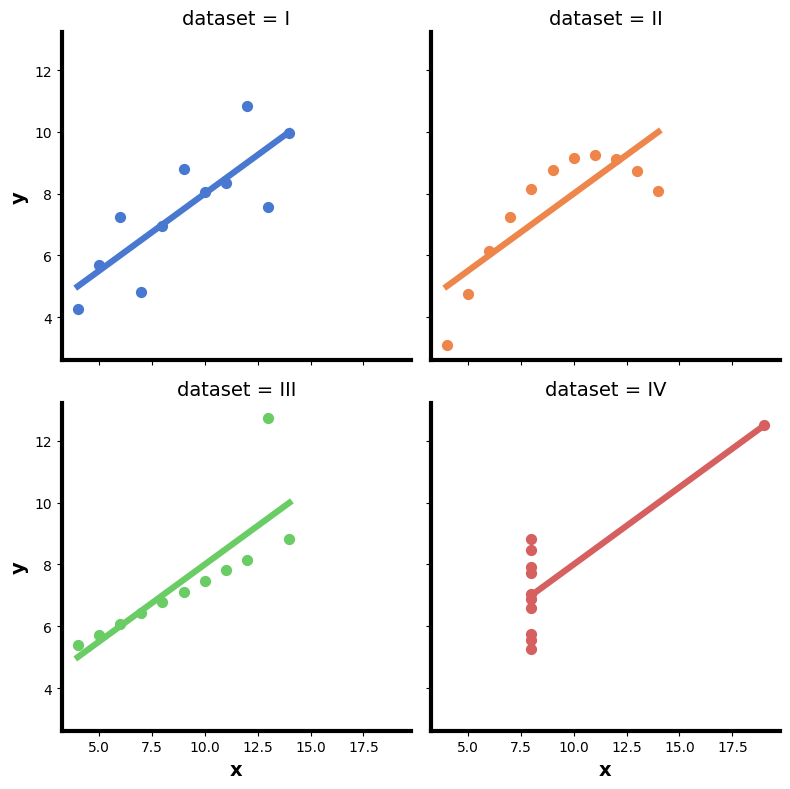

In [142]:
sns.lmplot(
    data=anscombe, x="x", y="y", col="dataset", hue="dataset",
    col_wrap=2, palette="muted", ci=None,
    height=4, scatter_kws={"s": 50, "alpha": 1}
)

### Give each dataset a meaningful name

In [143]:
anscombe_names = {'I': 'Normally distributed residuals', 'II': 'Model mismatch', 'III': 'Outlier', 'IV': 'Leverage'}
anscombe['name'] = anscombe['dataset'].map(anscombe_names)

### Add a small amount of noise so the statistics work better

In [144]:
mask = anscombe['name'] == 'Leverage'
anscombe.loc[mask, 'x'] += stats.norm.rvs(loc=0, scale=0.1, size=anscombe.loc[mask, 'x'].shape)

mask = anscombe['name'] == 'Outlier'
anscombe.loc[mask, 'y'] += stats.norm.rvs(loc=0, scale=0.5, size=anscombe.loc[mask, 'y'].shape)

### Plot each plot separately for the slides

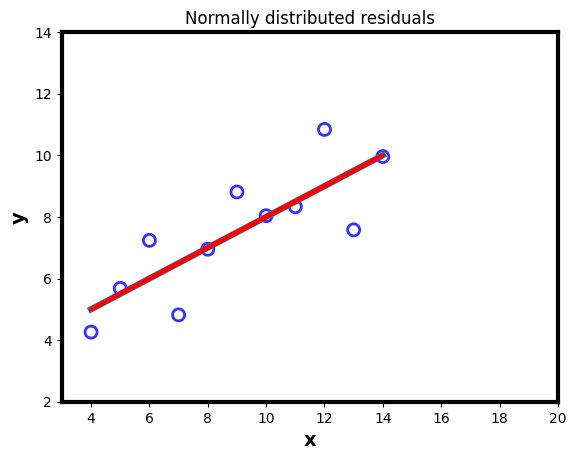

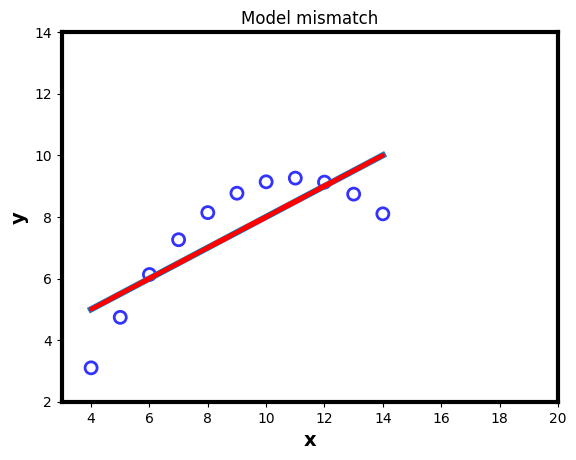

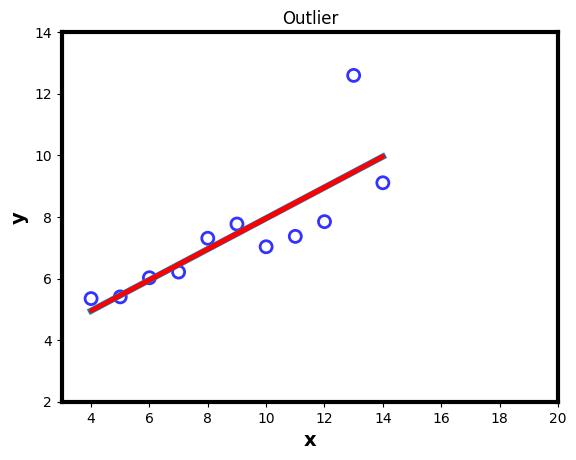

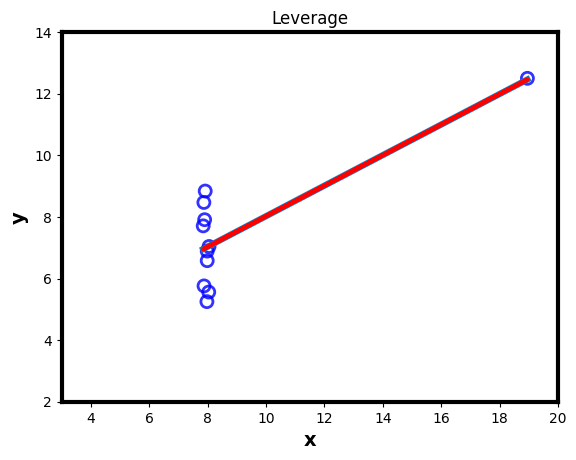

In [145]:
dataset_names = anscombe['name'].unique()

for name in dataset_names:
    # Subset the dataframe for the current dataset
    dataset = anscombe[anscombe['name'] == name]

    # Create a regression model
    X = dataset['x']
    X = sm.add_constant(X)
    y = dataset['y']
    model = sm.OLS(y, X)
    results = model.fit()

    # Plot the dataset
    plt.figure()
    sns.regplot(x='x', y='y', data=dataset, ci=None, scatter_kws={'s': 75, 'facecolors': 'none', 'edgecolors': 'blue', 'linewidths': 2})

    # Add a regression line
    plt.plot(dataset['x'], results.fittedvalues, color='red')

    plt.xlim([3, 20])
    plt.ylim([2, 14])

    # Set the title based on the dataset name
    plt.title(name)


### Report the statistics for each model

In [146]:
anscombe['residuals'] = np.zeros_like(anscombe['x'])

for name in dataset_names:
    # Subset the dataframe for the current dataset
    mask = anscombe['name'] == name
    dataset = anscombe[mask]

    # Create a regression model
    X = dataset['x']
    X = sm.add_constant(X)
    y = dataset['y']
    model = sm.OLS(y, X)
    results = model.fit()

    # Print regression coefficients and confidence intervals
    print(f"Dataset: {name}")
    print(results.summary().tables[1])
    print()

    # Calculate estimated population standard deviation
    residuals = results.resid
    s_yx = residuals.std(ddof=2)
    print(f"Estimated Population Standard Deviation: {s_yx}")
    print()

    # Calculate F-statistic and R-squared
    F_statistic = results.fvalue
    r_squared = results.rsquared
    print(f"F-statistic: {F_statistic}")
    print(f"R-squared: {r_squared}")
    print()

    standardized = residuals / s_yx
    influence = results.get_influence()
    leverage = influence.hat_matrix_diag
    studentized = standardized / np.sqrt(1-leverage)

    # Save residuals
    anscombe.loc[mask, 'residuals'] = residuals
    anscombe.loc[mask, 'standardized'] = standardized
    anscombe.loc[mask, 'leverage'] = leverage
    anscombe.loc[mask, 'studentized'] = studentized

Dataset: Normally distributed residuals
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0001      1.125      2.667      0.026       0.456       5.544
x              0.5001      0.118      4.241      0.002       0.233       0.767

Estimated Population Standard Deviation: 1.2366033227263211

F-statistic: 17.98994296767698
R-squared: 0.666542459508775

Dataset: Model mismatch
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0009      1.125      2.667      0.026       0.455       5.547
x              0.5000      0.118      4.239      0.002       0.233       0.767

Estimated Population Standard Deviation: 1.2372142053415771

F-statistic: 17.96564849227131
R-squared: 0.6662420337274844

Dataset: Outlier
                 coef    std err        

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## Analyze residuals

### Plot residuals

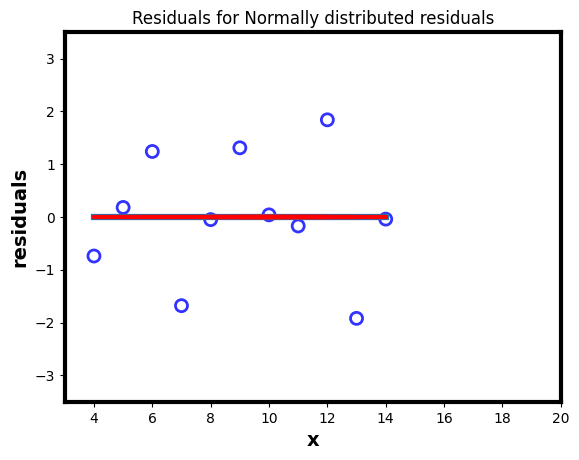

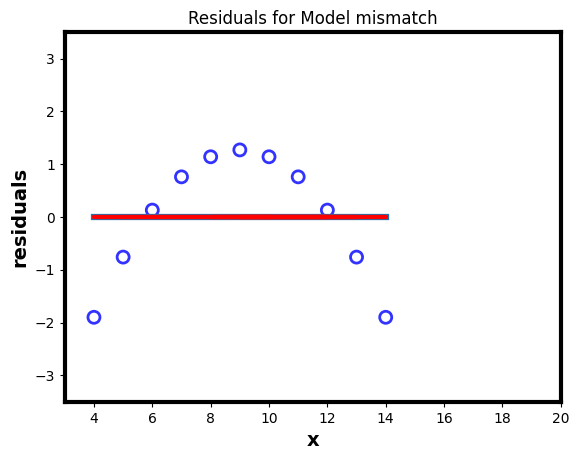

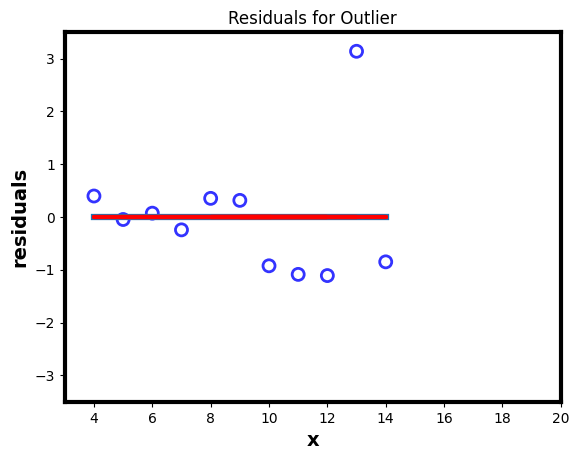

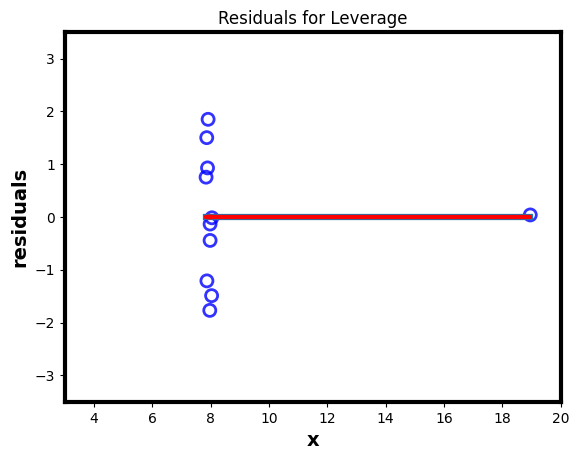

In [147]:
for name in dataset_names:
    # Subset the dataframe for the current dataset
    dataset = anscombe[anscombe['name'] == name]

    # Plot the dataset
    plt.figure()
    sns.regplot(x='x', y='residuals', data=dataset, ci=None, scatter_kws={'s': 75, 'facecolors': 'none', 'edgecolors': 'blue', 'linewidths': 2})

    # Add a zero line
    plt.plot(dataset['x'], np.zeros_like(dataset['x']), color='red')

    plt.xlim([3, 20])
    plt.ylim([-3.5, 3.5])

    # Set the title based on the dataset name
    plt.title('Residuals for ' + name)

### Plot standardized residuals

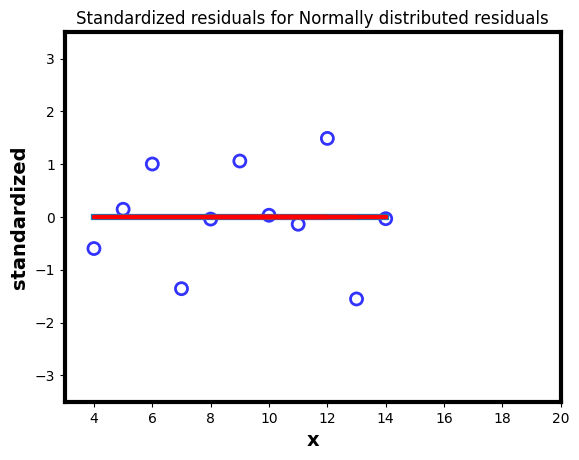

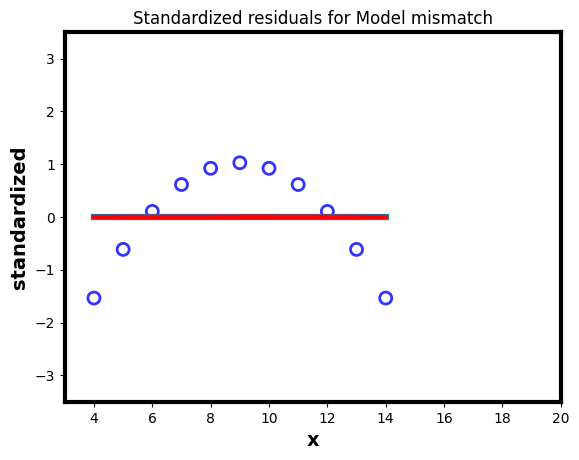

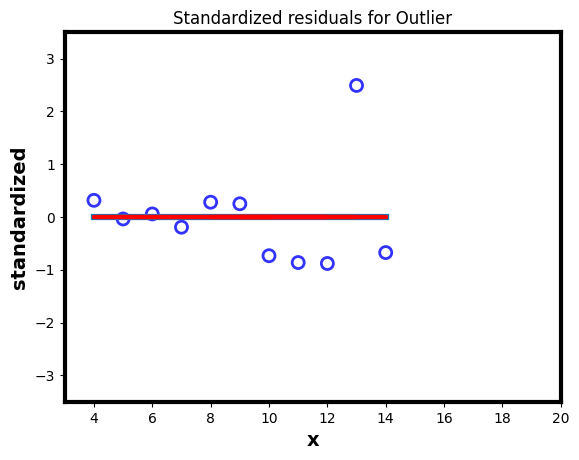

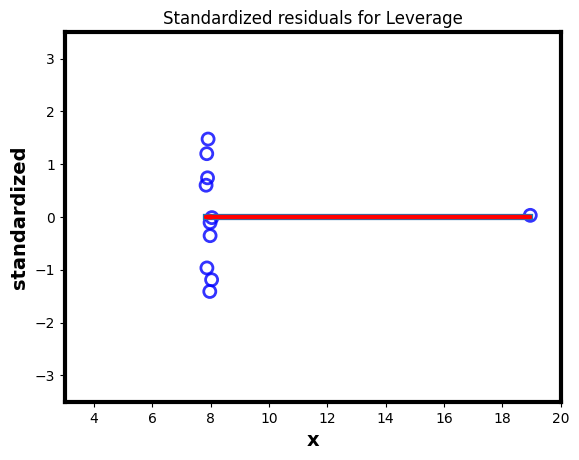

In [148]:
for name in dataset_names:
    # Subset the dataframe for the current dataset
    dataset = anscombe[anscombe['name'] == name]

    # Plot the dataset
    plt.figure()
    sns.regplot(x='x', y='standardized', data=dataset, ci=None, scatter_kws={'s': 75, 'facecolors': 'none', 'edgecolors': 'blue', 'linewidths': 2})

    # Add a zero line
    plt.plot(dataset['x'], np.zeros_like(dataset['x']), color='red')

    plt.xlim([3, 20])
    plt.ylim([-3.5, 3.5])

    # Set the title based on the dataset name
    plt.title('Standardized residuals for ' + name)

#### Plot leverage against standardized residuals

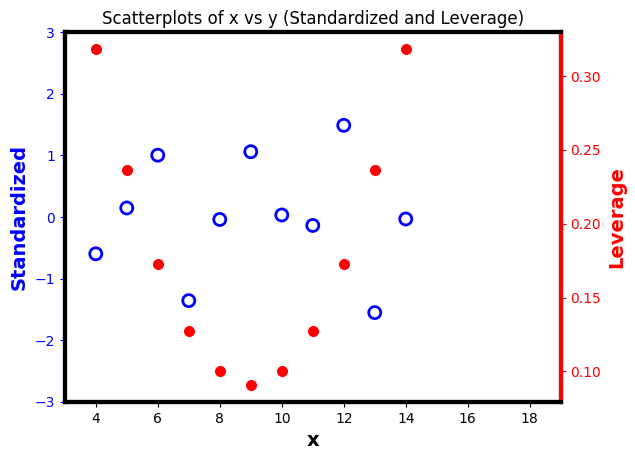

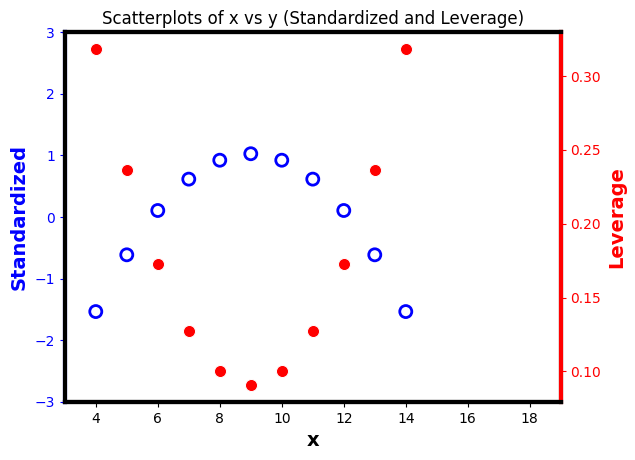

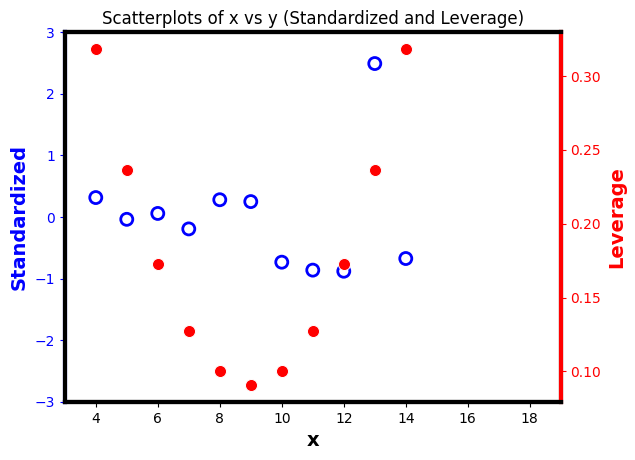

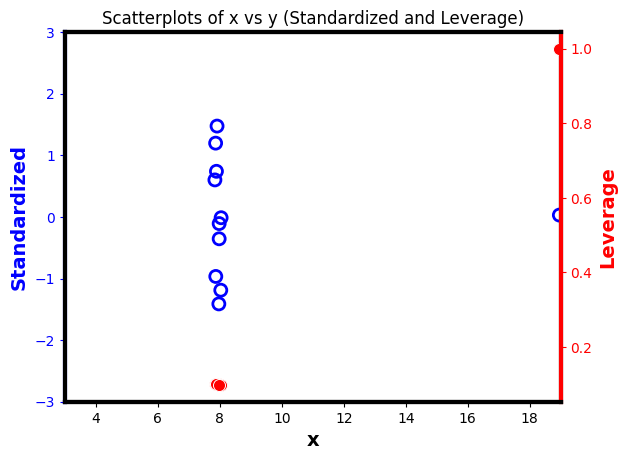

In [153]:
for name in dataset_names:
    # Subset the dataframe for the current dataset
    dataset = anscombe[anscombe['name'] == name]

    # Plot the dataset
    fig, ax_res = plt.subplots()

    # Scatterplot of x vs standardized
    sns.scatterplot(data=dataset, x='x', y='standardized', ax=ax_res, color='b',
                    edgecolor='b', linewidth=2, facecolor='none', s=75)
    ax_res.set_xlim([3, 19])
    ax_res.set_ylim([-3, 3])

    # Set the y-axis label for standardized data
    ax_res.set_ylabel('Standardized')

    ax_res.yaxis.label.set_color('b')
    ax_res.spines['left'].set_color('b')
    ax_res.tick_params(axis='y', colors='b')

    # Create a twin axis sharing the x-axis
    ax_lev = ax_res.twinx()

    # Scatterplot of x vs leverage
    sns.scatterplot(data=dataset, x='x', y='leverage', ax=ax_lev, color='r', s=75)
    ax_lev.set_xlim([3, 19])

    # Set the y-axis label for leverage data
    ax_lev.set_ylabel('Leverage')

    ax_lev.yaxis.label.set_color('r')
    ax_lev.spines['right'].set_color('r')
    ax_lev.tick_params(axis='y', colors='r')

    # Set the title and show the plot
    plt.title("Scatterplots of x vs y (Standardized and Leverage)")


### Plot studentized residuals

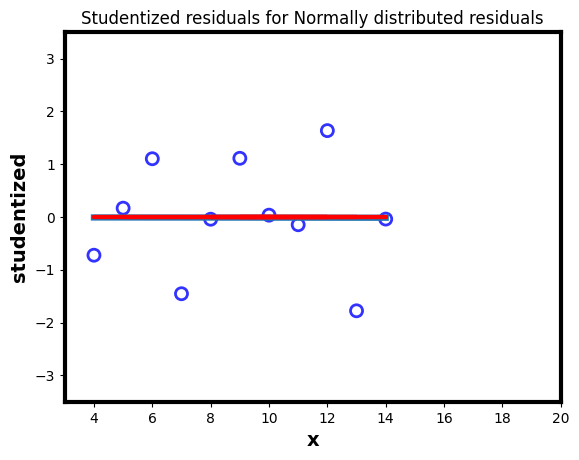

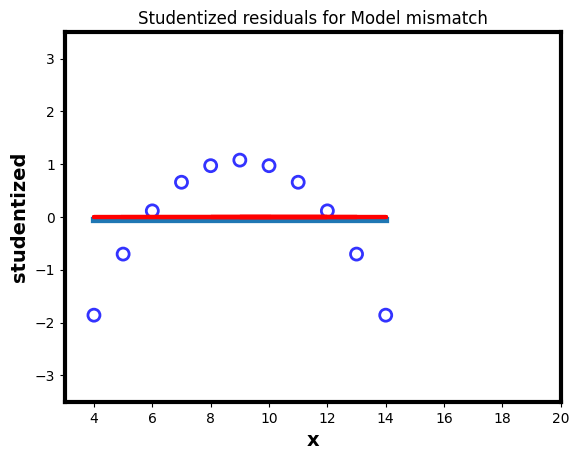

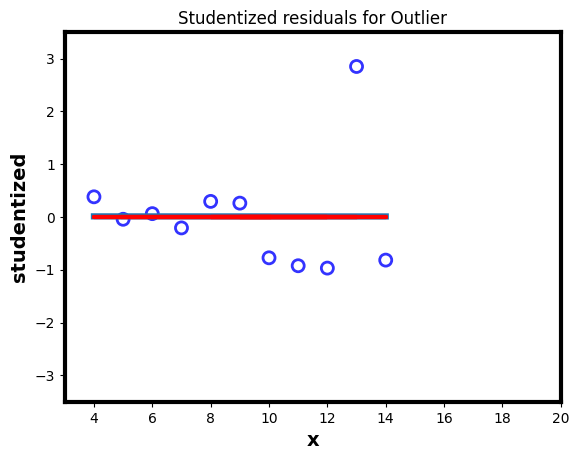

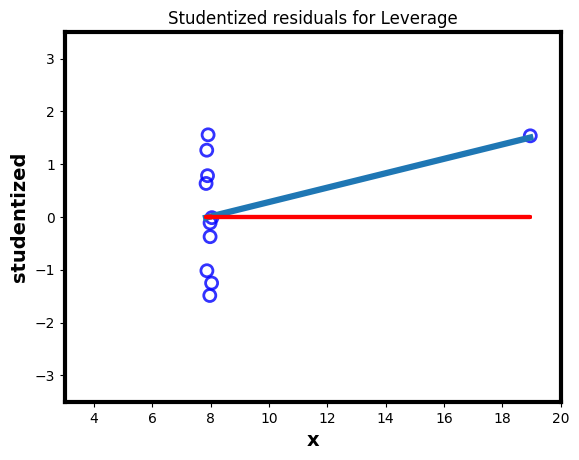

In [150]:
for name in dataset_names:
    # Subset the dataframe for the current dataset
    dataset = anscombe[anscombe['name'] == name]

    # Plot the dataset
    plt.figure()
    sns.regplot(x='x', y='studentized', data=dataset, ci=None, scatter_kws={'s': 75, 'facecolors': 'none', 'edgecolors': 'blue', 'linewidths': 2})

    # Add a zero line
    plt.plot(dataset['x'], np.zeros_like(dataset['x']), color='red')

    plt.xlim([3, 20])
    plt.ylim([-3.5, 3.5])

    # Set the title based on the dataset name
    plt.title('Studentized residuals for ' + name)

### Externalize or jacknife the residuals

In [151]:
for name in dataset_names:
    # Subset the dataframe for the current dataset
    mask = anscombe['name'] == name
    dataset = anscombe[mask].reset_index()

    externalized = np.zeros_like(dataset['y'])
    for i in range(len(dataset['y'])):
      x_loo = dataset['x'][i]
      y_loo = dataset['y'][i]
      leverage = dataset['leverage'][i]
      # Create a regression model
      X = dataset['x'].drop(index=i)
      X = sm.add_constant(X)
      y = dataset['y'].drop(index=i)
      model = sm.OLS(y, X)
      results = model.fit()

      y_hat_loo = results.predict(np.array([[1, x_loo]]))
      residual = y_loo - y_hat_loo

      s_yx = residuals.std(ddof=2)
      standardized = residual / s_yx
      studentized = standardized / np.sqrt(1-leverage)
      externalized[i] = studentized

    # Save residuals
    anscombe.loc[mask, 'externalized'] = externalized

### Plot externalized resdiuals

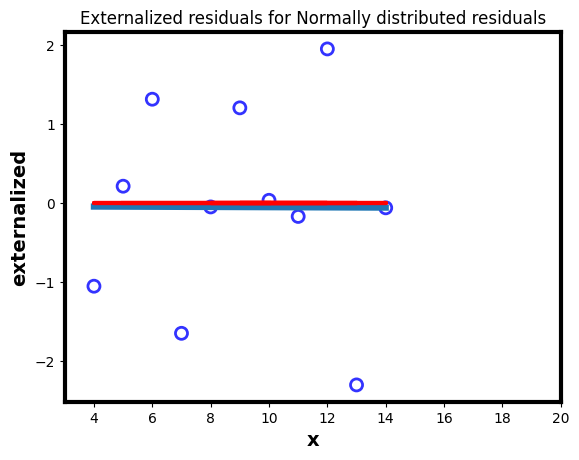

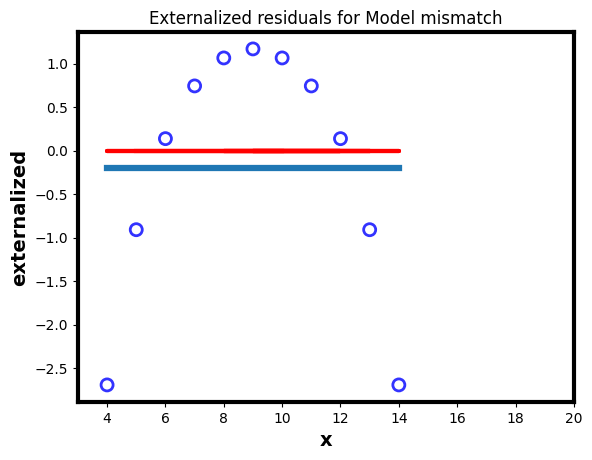

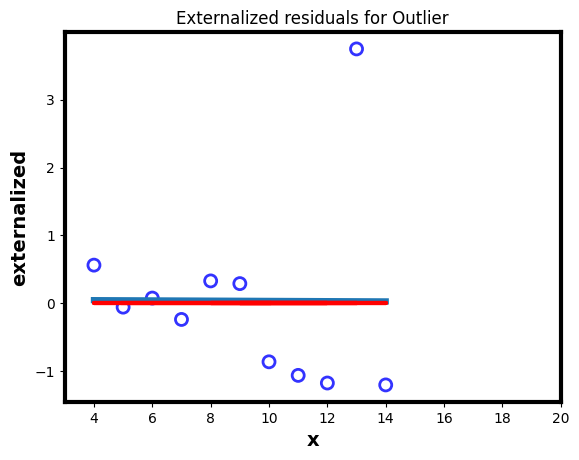

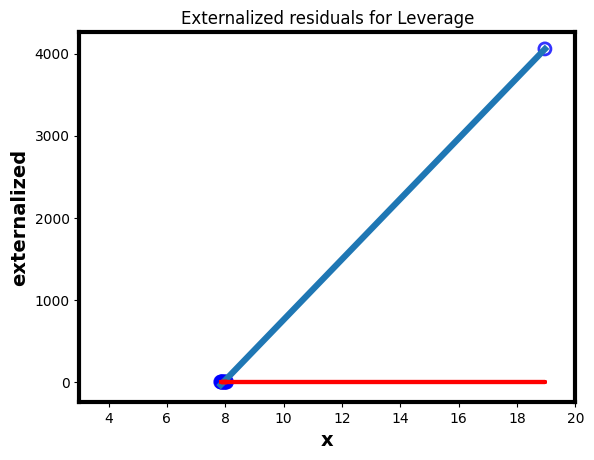

In [152]:
for name in dataset_names:
    # Subset the dataframe for the current dataset
    dataset = anscombe[anscombe['name'] == name]

    # Plot the dataset
    plt.figure()
    sns.regplot(x='x', y='externalized', data=dataset, ci=None, scatter_kws={'s': 75, 'facecolors': 'none', 'edgecolors': 'blue', 'linewidths': 2})

    # Add a zero line
    plt.plot(dataset['x'], np.zeros_like(dataset['x']), color='red')

    plt.xlim([3, 20])
    #plt.ylim([-3.5, 3.5])

    # Set the title based on the dataset name
    plt.title('Externalized residuals for ' + name)